# Прекод

# Сборный проект-5

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

In [3]:
!pip install torchvision transformers 

   ---------------------------------------- 0.0/9.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.7 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.7 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.7 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.7 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.7 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.7 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.7 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.7 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.7 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.7 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.7 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.7 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.7 MB ? eta -:--:--
   -- ----------------------------

In [4]:
import os
import math
import requests
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from PIL import Image
import copy
import random

# импортируем библиотеки для работы с progress bar
from tqdm import *
from tqdm.notebook import tqdm
tqdm.pandas()

# импортируем pytorch
import torch
import torch.nn as nn
from torchvision import transforms, models

# импортируем библиотеки для работы с текстом
from nltk.corpus import wordnet
from nltk.corpus import stopwords as nltk_stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from transformers import BertTokenizer

# импортируем класс GridSearchCV
from sklearn.model_selection import GridSearchCV

# загружаем нужные модели
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
# import lightgbm as lgb

In [5]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [6]:
set_seed(25)

Random seed set as 25


In [7]:
# os.environ['TORCH_HOME'] = 'models/resnet' #setting the environment variable\n

In [8]:
if torch.cuda.is_available():
    device = 'cuda'
    print(torch.cuda.get_device_name(0))
else:
    device = 'cpu'
    print('CPU')

NVIDIA GeForce GTX 1660 SUPER


Объявим константы для работы с проектом

In [9]:
DATA_FILENAME = "dsplus_integrated_project_4.zip"
DATA_URL = "https://code.s3.yandex.net/datasets/" + DATA_FILENAME
DATA_ROOT_FOLDER = "data/"
TRAIN_IMG_PATH = DATA_ROOT_FOLDER + "to_upload/train_images"
TEST_IMG_PATH =  DATA_ROOT_FOLDER + "to_upload/test_images"

In [10]:
def download_file(url, filename, path_to_file):
  with requests.get(url, stream=True) as r:
      r.raise_for_status()
      with open(filename, 'wb') as f:
          pbar = tqdm(total=int(r.headers['Content-Length']))
          for chunk in r.iter_content(chunk_size=8192):
              if chunk:
                  f.write(chunk)
                  pbar.update(len(chunk))

In [11]:
def extract_file(path_to_zip_file, directory_to_extract_to):
  with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
      zip_ref.extractall(directory_to_extract_to)

In [10]:
download_file(DATA_URL, DATA_FILENAME, DATA_ROOT_FOLDER)

  0%|          | 0/150987455 [00:00<?, ?it/s]

In [12]:
extract_file(DATA_FILENAME, DATA_ROOT_FOLDER)

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


In [13]:
def primary_information(df):
    display(df.info())
    display(df.head())

In [14]:
train_df = pd.read_csv(DATA_ROOT_FOLDER + "to_upload/train_dataset.csv")
primary_information(train_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


None

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


In [15]:
crowd_df = pd.read_csv(DATA_ROOT_FOLDER + "to_upload/CrowdAnnotations.tsv", sep="\t", names=[
    "filename", "description_id", "confirmed_percentage", "confirmed_qty", "disconfirmed_qty"
])
primary_information(crowd_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   filename              47830 non-null  object 
 1   description_id        47830 non-null  object 
 2   confirmed_percentage  47830 non-null  float64
 3   confirmed_qty         47830 non-null  int64  
 4   disconfirmed_qty      47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


None

,filename,description_id,confirmed_percentage,confirmed_qty,disconfirmed_qty
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


Файл с краудсорсинговыми оценками содержит 47830 строк, пропущенных значений нет

In [16]:
expert_df = pd.read_csv(DATA_ROOT_FOLDER + "to_upload/ExpertAnnotations.tsv", sep="\t", names=[
    "filename", "description_id", "exp1", "exp2", "exp3"
])
primary_information(expert_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   filename        5822 non-null   object
 1   description_id  5822 non-null   object
 2   exp1            5822 non-null   int64 
 3   exp2            5822 non-null   int64 
 4   exp3            5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


None

,filename,description_id,exp1,exp2,exp3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


Файл с экспертными оценками содержит 5822 строки, пропущенных значений нет

In [17]:
annotations_df = pd.merge(
    left=expert_df,
    right=crowd_df,
    how='left',
    left_on=['filename', 'description_id'],
    right_on=['filename', 'description_id'],
)
primary_information(annotations_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   filename              5822 non-null   object 
 1   description_id        5822 non-null   object 
 2   exp1                  5822 non-null   int64  
 3   exp2                  5822 non-null   int64  
 4   exp3                  5822 non-null   int64  
 5   confirmed_percentage  2329 non-null   float64
 6   confirmed_qty         2329 non-null   float64
 7   disconfirmed_qty      2329 non-null   float64
dtypes: float64(3), int64(3), object(2)
memory usage: 364.0+ KB


None

,filename,description_id,exp1,exp2,exp3,confirmed_percentage,confirmed_qty,disconfirmed_qty
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,0.0,0.0,3.0
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,0.0,0.0,3.0
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,NaN,NaN,NaN
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,NaN,NaN,NaN
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,NaN,NaN,NaN


Сделали левое объединение, получили 5822 строки. Если делать внутренние объединение, записей будет очень мало, а если внешние, то придется опираться на краудсорсинговые оценки, которые достаточно низкого качества. Поэтому левое объединение считаю наиболее оптимальным решением.

In [18]:
def target_calc(x):
    vals = [x['exp1'], x['exp2'], x['exp3']]
    diff = abs(sum(vals) - min(vals) - max(vals) - sum(vals) / 3.)
    if diff < 0.5:
        if math.isnan(x['confirmed_percentage']):
            return (sum(vals) / 3. - 1) / 3.
        else:
            return x['confirmed_percentage'] * 0.4 + (sum(vals) / 3. - 1) / 3. * 0.6
    if x['confirmed_percentage'] in [0, 1]:
        return x['confirmed_percentage']
    else:
        return None

С помощью функции `target_calc` посчитаем целевой признак, с учетом оценок экспертов и крауда в соотношении 3:2. Если мнения экспертов существенно разошлись, то в качестве таргета возьмем оценку крауда, но только в том случае, если эта оценка единогласная.

In [19]:
annotations_df['target'] = annotations_df.apply(target_calc, axis=1)

Посмотрим записи, которым неудалось присвоить таргет:

In [20]:
annotations_df[annotations_df['target'].isna()]

,filename,description_id,exp1,exp2,exp3,confirmed_percentage,confirmed_qty,disconfirmed_qty,target
490,1584315962_5b0b45d02d.jpg,3494394662_3edfd4a34c.jpg#2,1,3,3,NaN,NaN,NaN,NaN
1405,2445283938_ff477c7952.jpg,3280052365_c4644bf0a5.jpg#2,1,1,3,NaN,NaN,NaN,NaN
1667,2529116152_4331dabf50.jpg,3187395715_f2940c2b72.jpg#2,1,1,3,NaN,NaN,NaN,NaN
2122,2735558076_0d7bbc18fc.jpg,1536774449_e16b1b6382.jpg#2,2,4,4,0.333333,1.0,2.0,NaN
2336,2862004252_53894bb28b.jpg,1267711451_e2a754b4f8.jpg#2,1,3,3,0.333333,1.0,2.0,NaN
2342,2866254827_9a8f592017.jpg,2533424347_cf2f84872b.jpg#2,1,1,3,NaN,NaN,NaN,NaN
2628,2945036454_280fa5b29f.jpg,3613800013_5a54968ab0.jpg#2,1,3,3,NaN,NaN,NaN,NaN
2713,300314926_0b2e4b64f5.jpg,3214885227_2be09e7cfb.jpg#2,1,3,3,NaN,NaN,NaN,NaN
2755,3015863181_92ff43f4d8.jpg,2861932486_52befd8592.jpg#2,1,1,3,NaN,NaN,NaN,NaN
3001,3107513635_fe8a21f148.jpg,3213992947_3f3f967a9f.jpg#2,1,3,3,NaN,NaN,NaN,NaN


Таких записей немного, поэтому можно их удалить

In [21]:
annotations_df = annotations_df.dropna(subset=['target']).reset_index()[['filename', 'description_id', 'target']]

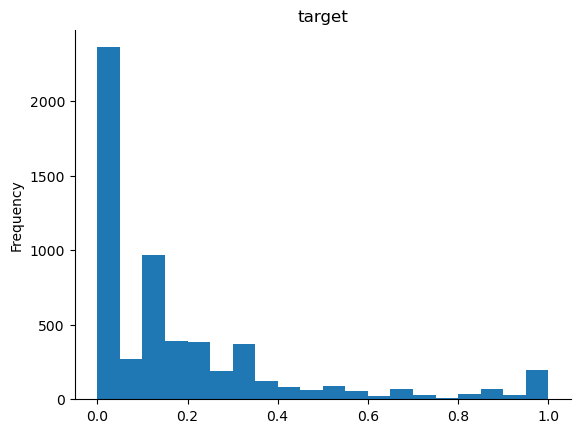

In [22]:
annotations_df['target'].plot(kind='hist', bins=20, title='target')
plt.gca().spines[['top', 'right',]].set_visible(False)

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [23]:
disclaimer_stopwords = ['child', 'boy', 'boys', 'girl', 'girls', 'kid', 'kids', 'children', 'baby', 'babies']

In [24]:
idx = train_df[train_df['query_text'].str.lower().str.extract(f"({'|'.join(disclaimer_stopwords)})").notna()[0]].index
print(f"Количество записей, попадающих под дисклеймер: {len(idx)}")
train_df = train_df.drop(idx).reset_index(drop=True)

Количество записей, попадающих под дисклеймер: 1553


In [25]:
primary_information(train_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       4269 non-null   object
 1   query_id    4269 non-null   object
 2   query_text  4269 non-null   object
dtypes: object(3)
memory usage: 100.2+ KB


None

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .
1,3187395715_f2940c2b72.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .
2,463978865_c87c6ca84c.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .
3,488590040_35a3e96c89.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .
4,534875358_6ea30d3091.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .


## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [33]:
resnet = models.resnet18(pretrained=True) #загружаем претренированную модель
if device == 'cuda':
    resnet = resnet.cuda()
for param in resnet.parameters():
    param.requires_grad_(False)

In [34]:
modules = list(resnet.children())[:-2]
resnet = nn.Sequential(*modules) 

In [35]:
resnet.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [36]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    ),
])

In [39]:
def create_embeddings(x):
    img = Image.open(f"{TRAIN_IMG_PATH}/{x}").convert('RGB')
    return resnet(preprocess(img).unsqueeze(0).to(device)).flatten()

In [40]:
%%time
train_df['image_embedding'] = train_df['image'].progress_apply(create_embeddings)

  0%|          | 0/4269 [00:00<?, ?it/s]

CPU times: total: 4min 1s
Wall time: 41.2 s


In [41]:
len(train_df['image_embedding'].iloc[1])

25088

In [42]:
train_df.sample(1).image_embedding.values[0]

tensor([2.1596, 3.8575, 3.5437,  ..., 0.4673, 0.2978, 0.0977], device='cuda:0')

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


In [43]:
lemmatizer = WordNetLemmatizer()

In [44]:
def lemmatize_text(text):
    # Переведем текст в нижний регистр
    text = text.lower()
    # Разложим на токены
    tokens = word_tokenize(text)
    # Приведем к каждому токену часть речи
    pos_tags = pos_tag(tokens)
    # Произведем лемматизацию в соответствии с частью речи
    lemmatized_tokens = [
        lemmatizer.lemmatize(token, get_wordnet_pos(pos)) for token, pos in pos_tags
    ]
    # Очистим текст от цифр и знаков препинания
    cleared_text = clear_text(" ".join(lemmatized_tokens))
    return cleared_text

In [45]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [46]:
def clear_text(text):
    clr_txt = re.sub(r'[^a-zA-Z]', ' ', text)
    clr_txt_list = clr_txt.split() 
    return ' '.join(clr_txt_list)

Произведем обработку текста

In [51]:
import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to C:\Users\Zhenya-
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Zhenya-PC\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger_eng.zip.


True

In [52]:
train_df['lemm_text'] = train_df.query_text.progress_apply(lemmatize_text)

  0%|          | 0/4269 [00:00<?, ?it/s]

In [53]:
train_df.lemm_text.head()

0    a man sleep under a blanket on a city street
1    a man sleep under a blanket on a city street
2    a man sleep under a blanket on a city street
3    a man sleep under a blanket on a city street
4    a man sleep under a blanket on a city street
Name: lemm_text, dtype: object

In [140]:
def create_text_embeddings(x):
    encoded_val = tokenizer.encode(x, padding='max_length')
    if device == 'cuda':
        encoded_val = torch.cuda.FloatTensor(encoded_val)
    return encoded_val

In [141]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_df['text_embedding'] = train_df.lemm_text.progress_apply(create_text_embeddings)
train_df.head()

  0%|          | 0/4269 [00:00<?, ?it/s]

,image,query_id,query_text,image_embedding,lemm_text,text_embedding
0,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,"[tensor(1.4565, device='cuda:0'), tensor(1.463...",a man sleep under a blanket on a city street,"[tensor(101., device='cuda:0'), tensor(1037., ..."
1,3187395715_f2940c2b72.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,"[tensor(0., device='cuda:0'), tensor(0., devic...",a man sleep under a blanket on a city street,"[tensor(101., device='cuda:0'), tensor(1037., ..."
2,463978865_c87c6ca84c.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,"[tensor(2.4619, device='cuda:0'), tensor(5.004...",a man sleep under a blanket on a city street,"[tensor(101., device='cuda:0'), tensor(1037., ..."
3,488590040_35a3e96c89.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,"[tensor(0.1198, device='cuda:0'), tensor(1.978...",a man sleep under a blanket on a city street,"[tensor(101., device='cuda:0'), tensor(1037., ..."
4,534875358_6ea30d3091.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,"[tensor(0., device='cuda:0'), tensor(0., devic...",a man sleep under a blanket on a city street,"[tensor(101., device='cuda:0'), tensor(1037., ..."


In [142]:
len(train_df['text_embedding'].iloc[1])

512

In [143]:
train_df.sample(1).text_embedding.values[0]

tensor([  101.,  1037.,  2374.,  2447.,  2022., 11147.,  1996.,  2447.,  2007.,
         1996.,  2374.,  1037.,  1996.,  4306.,  3422.,   102.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0., 

## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [144]:
df = pd.merge(
    left=train_df, 
    right=annotations_df,
    how='inner',
    left_on=['image', 'query_id'],
    right_on=['filename', 'description_id'],
)[['image', 'image_embedding', 'text_embedding', 'target']]

In [184]:
df

,image,image_embedding,text_embedding,target,embedding
0,1056338697_4f7d7ce270.jpg,"[tensor(1.4565, device='cuda:0'), tensor(1.463...","[tensor(101., device='cuda:0'), tensor(1037., ...",0.111111,"[tensor(1.4565), tensor(1.4630), tensor(0.0038..."
1,3187395715_f2940c2b72.jpg,"[tensor(0., device='cuda:0'), tensor(0., devic...","[tensor(101., device='cuda:0'), tensor(1037., ...",0.222222,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
2,463978865_c87c6ca84c.jpg,"[tensor(2.4619, device='cuda:0'), tensor(5.004...","[tensor(101., device='cuda:0'), tensor(1037., ...",0.200000,"[tensor(2.4619), tensor(5.0047), tensor(5.3163..."
3,488590040_35a3e96c89.jpg,"[tensor(0.1198, device='cuda:0'), tensor(1.978...","[tensor(101., device='cuda:0'), tensor(1037., ...",0.222222,"[tensor(0.1198), tensor(1.9786), tensor(2.7893..."
4,534875358_6ea30d3091.jpg,"[tensor(0., device='cuda:0'), tensor(0., devic...","[tensor(101., device='cuda:0'), tensor(1037., ...",0.111111,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
...,...,...,...,...,...
4250,799486353_f665d7b0f0.jpg,"[tensor(0., device='cuda:0'), tensor(0., devic...","[tensor(101., device='cuda:0'), tensor(1037., ...",0.000000,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
4251,799486353_f665d7b0f0.jpg,"[tensor(0., device='cuda:0'), tensor(0., devic...","[tensor(101., device='cuda:0'), tensor(1037., ...",0.000000,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
4252,909808296_23c427022d.jpg,"[tensor(0., device='cuda:0'), tensor(0., devic...","[tensor(101., device='cuda:0'), tensor(1037., ...",0.333333,"[tensor(0.), tensor(0.), tensor(0.2197), tenso..."
4253,929679367_ff8c7df2ee.jpg,"[tensor(0., device='cuda:0'), tensor(0., devic...","[tensor(101., device='cuda:0'), tensor(1037., ...",0.333333,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."


In [197]:
def concat_tensors(x):
    val = torch.cat((x['image_embedding'], x['text_embedding']), 0).cpu()
    return val 

In [212]:
df['embedding'] = df.apply(concat_tensors, axis=1)

In [213]:
primary_information(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4255 entries, 0 to 4254
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   image            4255 non-null   object 
 1   image_embedding  4255 non-null   object 
 2   text_embedding   4255 non-null   object 
 3   target           4255 non-null   float64
 4   embedding        4255 non-null   object 
dtypes: float64(1), object(4)
memory usage: 166.3+ KB


None

,image,image_embedding,text_embedding,target,embedding
0,1056338697_4f7d7ce270.jpg,"[tensor(1.4565, device='cuda:0'), tensor(1.463...","[tensor(101., device='cuda:0'), tensor(1037., ...",0.111111,"[tensor(1.4565), tensor(1.4630), tensor(0.0038..."
1,3187395715_f2940c2b72.jpg,"[tensor(0., device='cuda:0'), tensor(0., devic...","[tensor(101., device='cuda:0'), tensor(1037., ...",0.222222,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
2,463978865_c87c6ca84c.jpg,"[tensor(2.4619, device='cuda:0'), tensor(5.004...","[tensor(101., device='cuda:0'), tensor(1037., ...",0.200000,"[tensor(2.4619), tensor(5.0047), tensor(5.3163..."
3,488590040_35a3e96c89.jpg,"[tensor(0.1198, device='cuda:0'), tensor(1.978...","[tensor(101., device='cuda:0'), tensor(1037., ...",0.222222,"[tensor(0.1198), tensor(1.9786), tensor(2.7893..."
4,534875358_6ea30d3091.jpg,"[tensor(0., device='cuda:0'), tensor(0., devic...","[tensor(101., device='cuda:0'), tensor(1037., ...",0.111111,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."


In [214]:
df['embedding'].sample(1).values[0].shape

torch.Size([25600])

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

In [222]:
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['image']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

In [223]:
X_train = torch.FloatTensor(np.array(train_df['embedding'].values.tolist()))
y_train = torch.FloatTensor(np.array(train_df['target'].values.tolist()))
X_test = torch.FloatTensor(np.array(test_df['embedding'].values.tolist()))
y_test = torch.FloatTensor(np.array(test_df['target'].values.tolist()))

In [224]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2) 
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons) 
    
    def forward(self, x):
        out = self.fc1(x)
        out = torch.relu(out)
        out = self.fc2(out)
        out = torch.relu(out)
        out = self.fc3(out)
        out = torch.relu(out)
        
        return out

In [225]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = int(X_train.shape[1]/3*2)
n_hidden_neurons_2 = int(X_train.shape[1]/4.0)
n_out_neurons = 1 

In [226]:
lr=0.001
num_epochs = 50
per_epochs = 10

In [227]:
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))

In [228]:
net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

loss = RMSELoss
rmse_min = float('inf')
best_params = None

for epoch in range(num_epochs):
    optimizer.zero_grad()
    preds = net.forward(X_train).flatten()
    loss_value = loss(preds, y_train)
    loss_value.backward()
    optimizer.step()

    if epoch % per_epochs == 0 or epoch == num_epochs - 1:
        net.eval()
        test_preds = net.forward(X_test).flatten()
        rmse = loss(test_preds, y_test)
        if rmse_min > rmse:
            rmse_min = rmse
            best_params = copy.deepcopy(net.state_dict())
        print(f"Epoch {epoch}/{num_epochs}, RMSE = {rmse}, best RMSE = {rmse_min}")

Epoch 0/50, RMSE = 0.31617775559425354, best RMSE = 0.31617775559425354
Epoch 10/50, RMSE = 0.31617775559425354, best RMSE = 0.31617775559425354


KeyboardInterrupt: 

In [235]:
import random
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

In [236]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = int(X_train.shape[1]*2.0/3.0)
n_hidden_neurons_2 = int(X_train.shape[1]/3.0)
n_out_neurons = 1 

net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.Tanh(),
    nn.Linear(n_hidden_neurons_2, n_out_neurons), 
    nn.Sigmoid()
)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

loss = nn.MSELoss()

num_epochs = 50

In [ ]:
for epoch in range(num_epochs):
    optimizer.zero_grad()

    preds = net.forward(X_train).flatten()

    loss_value = loss(preds, y_train)

    loss_value.backward()

    optimizer.step()

    if epoch % 10 == 0 or epoch == num_epochs - 1:
        net.eval()
        test_preds = net.forward(X_test)
        accuracy = torch.abs(test_preds - y_test).float().mean().data
        print(f'Epoch {epoch}: {accuracy}')

In [67]:
best_basic_rmse = rmse_min
print(f"Лучшая метрика: {best_basic_rmse:.3f}")

Лучшая метрика: 0.316


In [68]:
net.load_state_dict(best_params)

<All keys matched successfully>

In [71]:
n = 100
test_preds[:n]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], grad_fn=<SliceBackward0>)

Text(0.5, 0, 'Image')

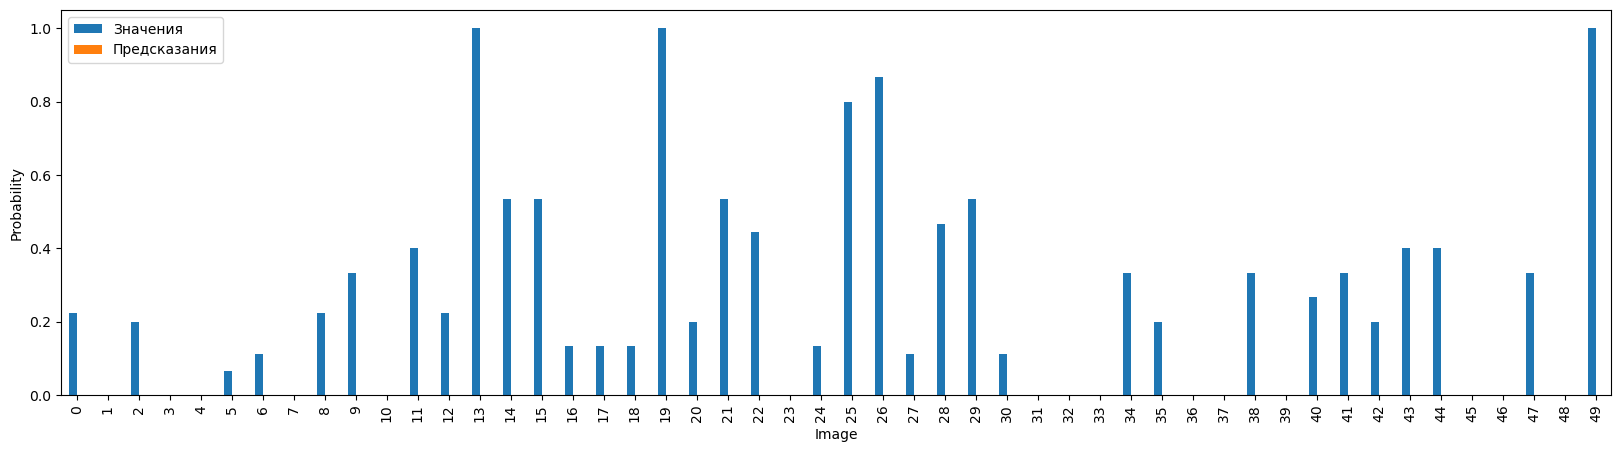

In [234]:
test_preds = net.forward(X_test).flatten()
y_test_df = pd.DataFrame(y_test.detach().numpy())
test_preds_df = pd.DataFrame(test_preds.detach().numpy())
res_df = pd.concat([y_test_df, test_preds_df], axis=1)[:50]
fig = res_df.plot(kind='bar', figsize=(20, 5))
fig.legend(['Значения', 'Предсказания'])
fig.set_ylabel('Probability')
fig.set_xlabel('Image')

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [ ]:
TEST_IMG_PATH = 'sp5/train_images'

In [ ]:
test_queries_df = pd.read_csv("sp5/test_queries.csv", sep="|")
primary_information(test_queries_df)

## 8. Выводы

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Проверены экспертные оценки и краудсорсинговые оценки
- [ ]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [ ]  Изображения векторизованы
- [ ]  Текстовые запросы векторизованы
- [ ]  Данные корректно разбиты на тренировочную и тестовую выборки
- [ ]  Предложена метрика качества работы модели
- [ ]  Предложена модель схожести изображений и текстового запроса
- [ ]  Модель обучена
- [ ]  По итогам обучения модели сделаны выводы
- [ ]  Проведено тестирование работы модели
- [ ]  По итогам тестирования визуально сравнили качество поиска